# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [1]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
#загрузим датасеты
try:
    df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Some other exception")

## Подготовка данных

На этом этапе изучим общую информацию о датасетах.

### Данные об электродах

Этими графитовыми электродами подогревают сталь до нужной температуры.

In [3]:
df_arc.sample(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
5932,1292,2019-06-18 23:41:02,2019-06-18 23:45:02,0.998083,0.918491
1676,361,2019-05-17 02:12:44,2019-05-17 02:14:48,0.425813,0.311488
974,210,2019-05-11 01:14:03,2019-05-11 01:16:33,0.520379,0.387384
866,183,2019-05-10 04:38:34,2019-05-10 04:42:07,0.769795,0.616236
4387,944,2019-06-07 08:49:47,2019-06-07 08:52:54,0.663982,0.485957


In [4]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


В данном датасете 5 столбцов и 14 876 строк. Пропусков нет. Столбцы "Начало нагрева дугой" и "Конец нагрева дугой" нужно привести к типу datetime.

In [5]:
#изменим тип данных на datetime
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
#и проверим, что тип данных успешно изменен
df_arc.dtypes

key                              int64
Начало нагрева дугой    datetime64[ns]
Конец нагрева дугой     datetime64[ns]
Активная мощность              float64
Реактивная мощность            float64
dtype: object

In [6]:
#проверим датасет на наличие дубликатов
print('Количество дубликатов в датасете df_arc:', df_arc.duplicated().sum())

Количество дубликатов в датасете df_arc: 0


In [7]:
#посмотрим описательную статистику
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


В реактивной мощности есть явный выброс, равный -715.504924.

<AxesSubplot:xlabel='Реактивная мощность'>

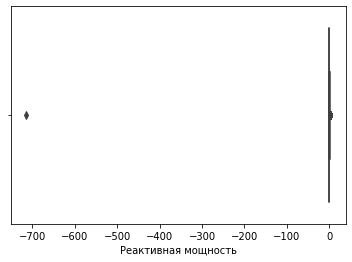

In [8]:
#посмотрим на boxplot, чтобы подтвердить, что это выброс
sns.boxplot(df_arc['Реактивная мощность'])

Да, это явный выброс и от него нужно избавиться.

In [9]:
df_arc[df_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [10]:
#проверим, что эта строка не последняя в партии
df_arc[df_arc['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [11]:
#всего одна позиция, можно удалить
df_arc = df_arc[df_arc['Реактивная мощность'] >= 0]

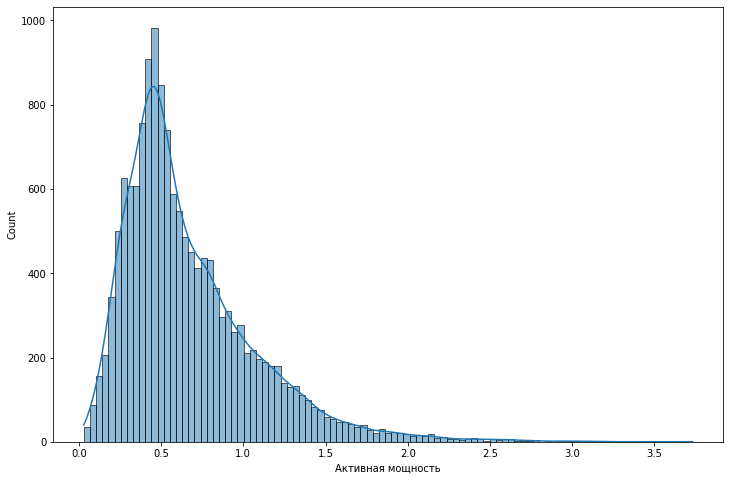

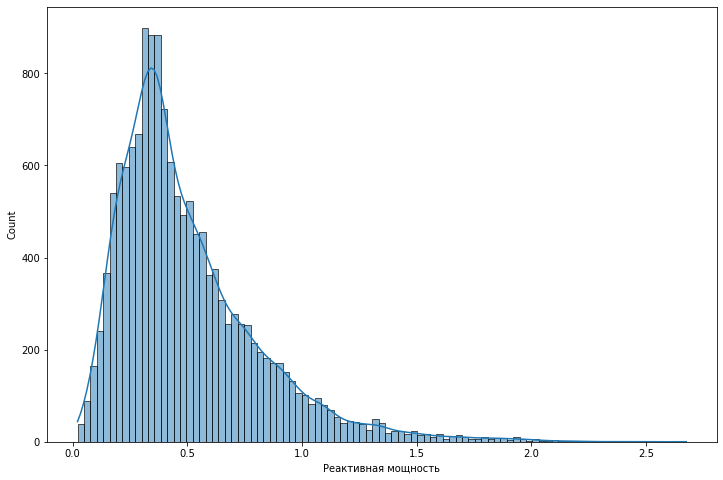

In [12]:
#рассмотрим плотность распределения
plt.figure(figsize=(12,8))
sns.histplot(df_arc['Активная мощность'], kde=True)
plt.show()

plt.figure(figsize=(12,8))
sns.histplot(df_arc['Реактивная мощность'], kde=True)
plt.show()

В целом распределение нормальное с перекосом вправо.

#### Итог по датасету с данными об электродах.
1. В датасете 14 876 строк и 5 столбцов.
2. Пропусков и дубликатов нет.
3. Столбцы `Начало нагрева дугой` и `Конец нагрева дугой` приведены к типу `datetime`.
4. Был удален один выброс.

### Данные о подаче сыпучих материалов (объем и время)

Сыпучие материалы используются для легирования стали и изменения химического состава сплава.

In [13]:
df_bulk.sample(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1886,1949,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN,NaN,50.0,206.0,NaN,200.0,NaN
2238,2319,NaN,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,36.0,NaN,257.0,NaN,108.0,224.0
2505,2598,NaN,NaN,NaN,NaN,NaN,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.0,NaN
1250,1301,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,257.0,NaN,135.0,203.0
1096,1144,NaN,NaN,395.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,509.0,NaN,204.0,204.0


In [14]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [15]:
print('Количество дубликатов в датасете df_bulk:', df_bulk.duplicated().sum())

Количество дубликатов в датасете df_bulk: 0


In [16]:
df_bulk_time.sample(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1093,1141,NaN,NaN,NaN,NaN,2019-06-13 23:19:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
515,544,NaN,NaN,NaN,NaN,NaN,2019-05-23 11:26:21,NaN,NaN,NaN,NaN,NaN,2019-05-23 11:19:16,NaN,2019-05-23 11:19:16,2019-05-23 11:19:16
1305,1357,NaN,NaN,NaN,2019-06-21 10:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-21 10:28:43,NaN,2019-06-21 10:28:43,2019-06-21 10:28:43
1777,1839,NaN,NaN,2019-07-07 18:16:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
862,898,NaN,NaN,NaN,2019-06-05 12:05:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-05 11:42:28,NaN,2019-06-05 11:42:28,2019-06-05 11:42:28


In [17]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [18]:
print('Количество дубликатов в датасете df_bulk_time:', df_bulk_time.duplicated().sum())

Количество дубликатов в датасете df_bulk_time: 0


В представленных датасетах по 3129 строк и по 16 столбцов. Дубликатов нет. Данные во всех столбцах кроме 'key' типа object. Очень много пропусков и я связываю это с тем, что данные примеси добавлялись не в каждый сплав и не каждый раз, а только при необходимости изменить состав. Количество пропусков и заполненных значений по каждому столбцу в обеих таблицах совпадают. Проводить дальнейший анализ данных датасетов не вижу особого смысла, потому что в связи с непостоянством использования данных материалов будет много выбросов и аномалий.

### Данные о проволочных материалах (объем и время)

Следом рассмотрим датасеты с проволочными материалами, т.к. они тоже используются для легирования стали.

In [19]:
df_wire.sample(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
60,69,191.362092,9.085441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2599,2733,97.056953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2200,2311,101.075520,41.258881,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2866,3019,159.126236,23.223200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
443,475,97.811997,13.210080,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [21]:
print('Количество дубликатов в датасете df_wire:', df_wire.duplicated().sum())

Количество дубликатов в датасете df_wire: 0


In [22]:
df_wire_time.sample(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
597,633,2019-05-26 16:47:29,2019-05-26 16:47:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,2110,2019-07-23 19:15:41,NaN,2019-07-23 18:07:01,2019-07-23 18:09:32,NaN,2019-07-23 18:02:33,2019-07-23 19:16:46,NaN,NaN
1076,1143,2019-06-14 01:03:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1406,1478,2019-06-25 18:26:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2678,2819,2019-08-17 18:23:09,2019-08-17 18:23:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [24]:
print('Количество дубликатов в датасете df_wire_time:', df_wire_time.duplicated().sum())

Количество дубликатов в датасете df_wire_time: 0


В данных датасетах по 3081 строке и по 10 столбцов. Дубликатов нет. Данные во всех столбцах кроме 'key' типа object.

Здесь мы видим точно такую же картину, как и в предыдущих датасетах: очень много пропусков, количество пропусков в каждом столбце обоих датасетов совпадают, проволока Wire 5 использовалась всего один раз, но при этом проволока Wire 1 использовалась в 99 % случаев.

### Данные о продувке сплава газом

Газ используется для продувки сплава после добавления легирующих материалов.

In [25]:
df_gas.sample(5)

,key,Газ 1
699,702,15.429043
2807,2810,8.286403
677,680,9.893150
1035,1038,8.382230
1592,1595,12.107606


In [26]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [27]:
print('Количество дубликатов в датасете df_gas:', df_gas.duplicated().sum())

Количество дубликатов в датасете df_gas: 0


В данном датасете 3239 строк и всего 2 столбца. Пропусков и дубликатов нет.

In [28]:
#посмотрим на описательную статистику
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Максимальное значение в 77.99 выглядит как выброс. Построим boxplot.

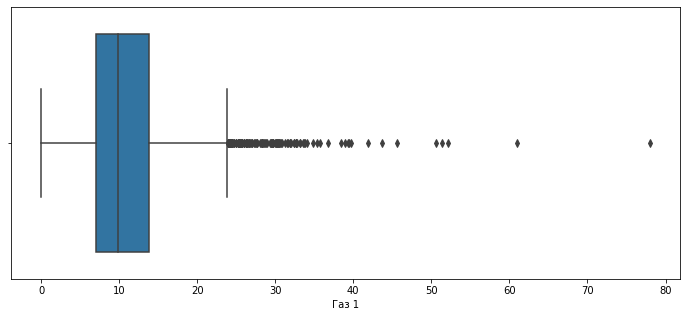

In [29]:
plt.figure(figsize=(12,5))
sns.boxplot(df_gas['Газ 1'])
plt.show()

Судя по boxplot явные выбросы начинаются после 40. Рассчитаем точное значение начала выбросов по формуле: q_3 (3 квартиль) + 3 * irq (межквартильный размах). Получается, что 13,76 + 3*(13,76 - 7,04) = 33,92 и все значения с 34 это выбросы.

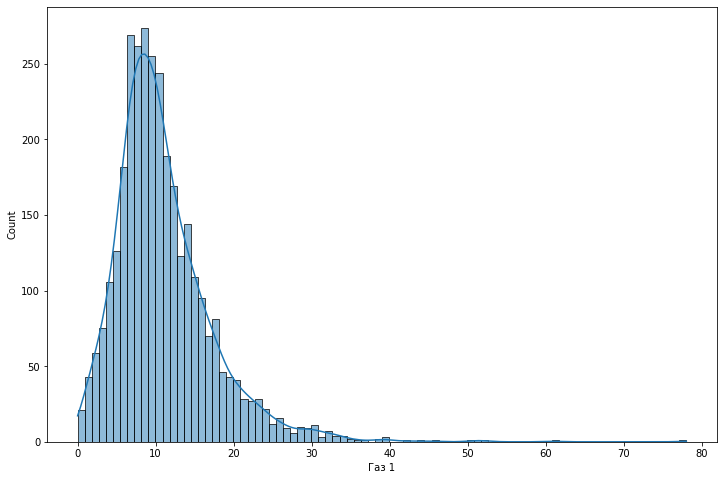

In [30]:
#рассмотрим плотность распределения
plt.figure(figsize=(12,8))
sns.histplot(df_gas['Газ 1'], kde=True)
plt.show()

Распределение нормальное.

### Результаты измерения температуры

In [31]:
df_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [32]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [33]:
print('Количество дубликатов в датасете df_temp:', df_temp.duplicated().sum())

Количество дубликатов в датасете df_temp: 0


В данном датасете 15 907 строк и 3 столбца. В столбце "Температура" есть 2 906 пропусков. Дубликаты отсутствуют

In [34]:
#сразу приведем "Время замера" к типу datetime
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')
df_temp.dtypes

key                      int64
Время замера    datetime64[ns]
Температура            float64
dtype: object

In [35]:
#взглянем на описательную статистику
df_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


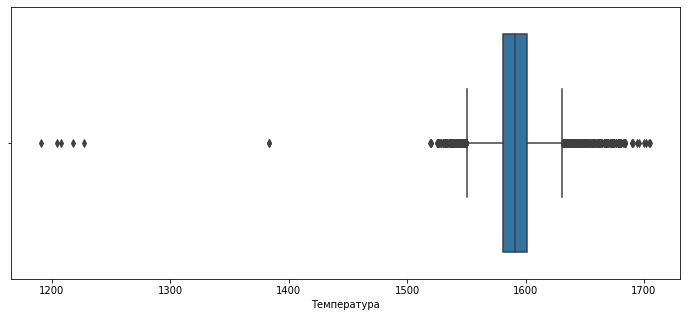

In [36]:
#построим boxplot
plt.figure(figsize=(12,5))
sns.boxplot(df_temp['Температура'])
plt.show()

Есть выбросы в промежутке до 1400 градусов. Посмотрим на распределение.

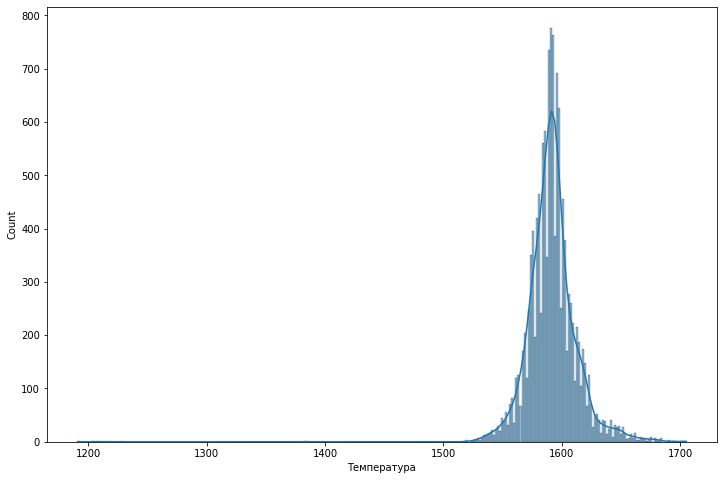

In [37]:
plt.figure(figsize=(12,8))
sns.histplot(df_temp['Температура'], kde=True)
plt.show()

Распределение абсолютно нормальное.

## Предобработка данных

Рассчитаем полную мощность и продолжительность нагрева графитовыми электродами.

In [38]:
#добавление столбца с полной мощностью
df_arc['full_power'] = np.sqrt(df_arc['Активная мощность']**2 + df_arc['Реактивная мощность']**2)

#рассчитаем продолжительность нагрева в секундах
df_arc['heating_time'] = ((df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой'])
                          .dt.total_seconds().astype(int))

#сгруппируем данные по ключу и создадим финальный датасет
df_arc_final=df_arc.groupby('key').sum()[['full_power', 'heating_time']].reset_index()

#посмотрим на получившийся датасет
df_arc_final

,key,full_power,heating_time
0,1,5.826395,1098
1,2,3.649216,811
2,3,2.989534,655
3,4,3.814962,741
4,5,4.035758,869
...,...,...,...
3209,3237,4.844982,909
3210,3238,2.696542,546
3211,3239,5.611883,1216
3212,3240,3.891856,839


Теперь заполним пропуски нулями в датасетах df_bulk и df_wire.

In [39]:
df_bulk = df_bulk.fillna(0)
df_wire = df_wire.fillna(0)

#проверим результат
display(df_bulk.sample(3))
display(df_wire.sample(3))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2619,2718,0.0,0.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202.0,0.0,150.0,108.0
1477,1533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,258.0,0.0,150.0,205.0
2945,3054,0.0,0.0,104.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,360.0,0.0,194.0,262.0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
865,919,46.144798,132.100800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1076,1143,139.183196,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1521,1600,104.083198,133.367524,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Как мы уже определили ранее, в датасете с газом значения выше 34 являются выбросами. Отфильтруем датасет и уберем эти 18 строк.

In [40]:
df_gas = df_gas[df_gas['Газ 1'] < 34]

In [41]:
#переименуем в датасете df_gas название столбца, чтобы в финальном датасете все столбцы были в одном стиле
df_gas = df_gas.rename(columns = {'Газ 1': 'gas'})
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3221 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3221 non-null   int64  
 1   gas     3221 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.5 KB


Перейдем к финальному датасету с температурой. Из него нужно удалить выбросы менее 1300 градусов, т.к. 1300 градусов является начальной температурой плавления стали. После этого удалим из датасета партии, в которых только одно время замера, а нам нужны как минимум 2, т.к. начальная температура является признаком, а конечная температура - это целевой признак. Также нужно выделить начальную и конечную температуру одной партии и время работы с партией.

In [42]:
#отфильтруем выбросы ниже 1300 градусов
df_temp = df_temp.query('Температура >= 1300')

In [43]:
#группируем данные по ключу и считаем количество замеров
temp_count = (df_temp.groupby('key')['key'].count())\
             [(df_temp.groupby('key')['key'].count()) > 1].index

#удаляем индексы с одним замером из датасета
df_temp = df_temp[df_temp['key'].isin(temp_count)]

In [44]:
#создаем датасет с группировкой по ключу и агрегирующей функцией min, примененной к времени замера
start_temp = df_temp.groupby('key').agg('min')['Время замера']
start_temp = pd.DataFrame(start_temp)
start_temp = start_temp.merge(df_temp, on='Время замера', how='left')
start_temp.set_axis(['start_time', 'key', 'start_temp'], axis = 'columns', inplace = True)


#создаем второй датасет с группировкой по ключу и агрегирующей функцией max, примененной к времени замера
final_temp = df_temp.groupby('key').agg('max')['Время замера']
final_temp = pd.DataFrame(final_temp)
final_temp = final_temp.merge(df_temp, on='Время замера', how='left')
final_temp.set_axis(['final_time', 'key', 'final_temp'], axis = 'columns', inplace = True)

#объединим таблицы в датасет
df_final_temp = start_temp.merge(final_temp, on='key', how='left')\
                  .reindex(columns=['key', 'start_time', 'start_temp', 'final_time', 'final_temp'])

#добавим столбец с продолжительностью работы с партией
df_final_temp['duration'] = ((df_final_temp['final_time'] - df_final_temp['start_time'])
                             .dt.total_seconds().astype(int))

#оставим только нужные столбцы
df_final_temp = df_final_temp[['key', 'start_temp', 'final_temp', 'duration']]

df_final_temp

,key,start_temp,final_temp,duration
0,1,1571.0,1613.0,861
1,2,1581.0,1602.0,1305
2,3,1596.0,1599.0,1300
3,4,1601.0,1625.0,388
4,5,1576.0,1602.0,762
...,...,...,...,...
2470,2495,1570.0,1591.0,1137
2471,2496,1554.0,1591.0,1618
2472,2497,1571.0,1589.0,717
2473,2498,1591.0,1594.0,1302


In [45]:
print('Количество пропусков в датасете:', df_final_temp.isna().sum().sum())

Количество пропусков в датасете: 0


Объединим данные для финального датасета.

In [46]:
df_final = df_final_temp.merge(df_arc_final, on='key')
df_final = df_final.merge(df_gas, on='key')
df_final = df_final.merge(df_bulk, on='key')
df_final = df_final.merge(df_wire, on='key')
display(df_final.sample(5))
df_final.info()

,key,start_temp,final_temp,duration,full_power,heating_time,gas,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1616,1738,1577.0,1600.0,999,3.758005,719,9.699940,0.0,0.0,0.0,...,203.0,143.067596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
544,597,1606.0,1599.0,1470,1.707895,358,7.584491,0.0,0.0,0.0,...,0.0,165.204010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
815,892,1615.0,1595.0,1221,1.372468,298,6.722087,0.0,0.0,0.0,...,102.0,102.726000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,2161,1614.0,1591.0,2112,2.688493,624,11.674069,0.0,0.0,0.0,...,228.0,64.122238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
432,481,1590.0,1601.0,2066,4.933154,952,9.359756,0.0,0.0,342.0,...,103.0,65.239197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2313 entries, 0 to 2312
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2313 non-null   int64  
 1   start_temp    2313 non-null   float64
 2   final_temp    2313 non-null   float64
 3   duration      2313 non-null   int32  
 4   full_power    2313 non-null   float64
 5   heating_time  2313 non-null   int32  
 6   gas           2313 non-null   float64
 7   Bulk 1        2313 non-null   float64
 8   Bulk 2        2313 non-null   float64
 9   Bulk 3        2313 non-null   float64
 10  Bulk 4        2313 non-null   float64
 11  Bulk 5        2313 non-null   float64
 12  Bulk 6        2313 non-null   float64
 13  Bulk 7        2313 non-null   float64
 14  Bulk 8        2313 non-null   float64
 15  Bulk 9        2313 non-null   float64
 16  Bulk 10       2313 non-null   float64
 17  Bulk 11       2313 non-null   float64
 18  Bulk 12       2313 non-null 

Получили итоговый датасет, состоящий из 2313 строк и 31 столбца. Пропусков нет.

Теперь проверим корелляцию признаков между собой, может какие-то можно удалить, чтобы модель обучалась быстрее.

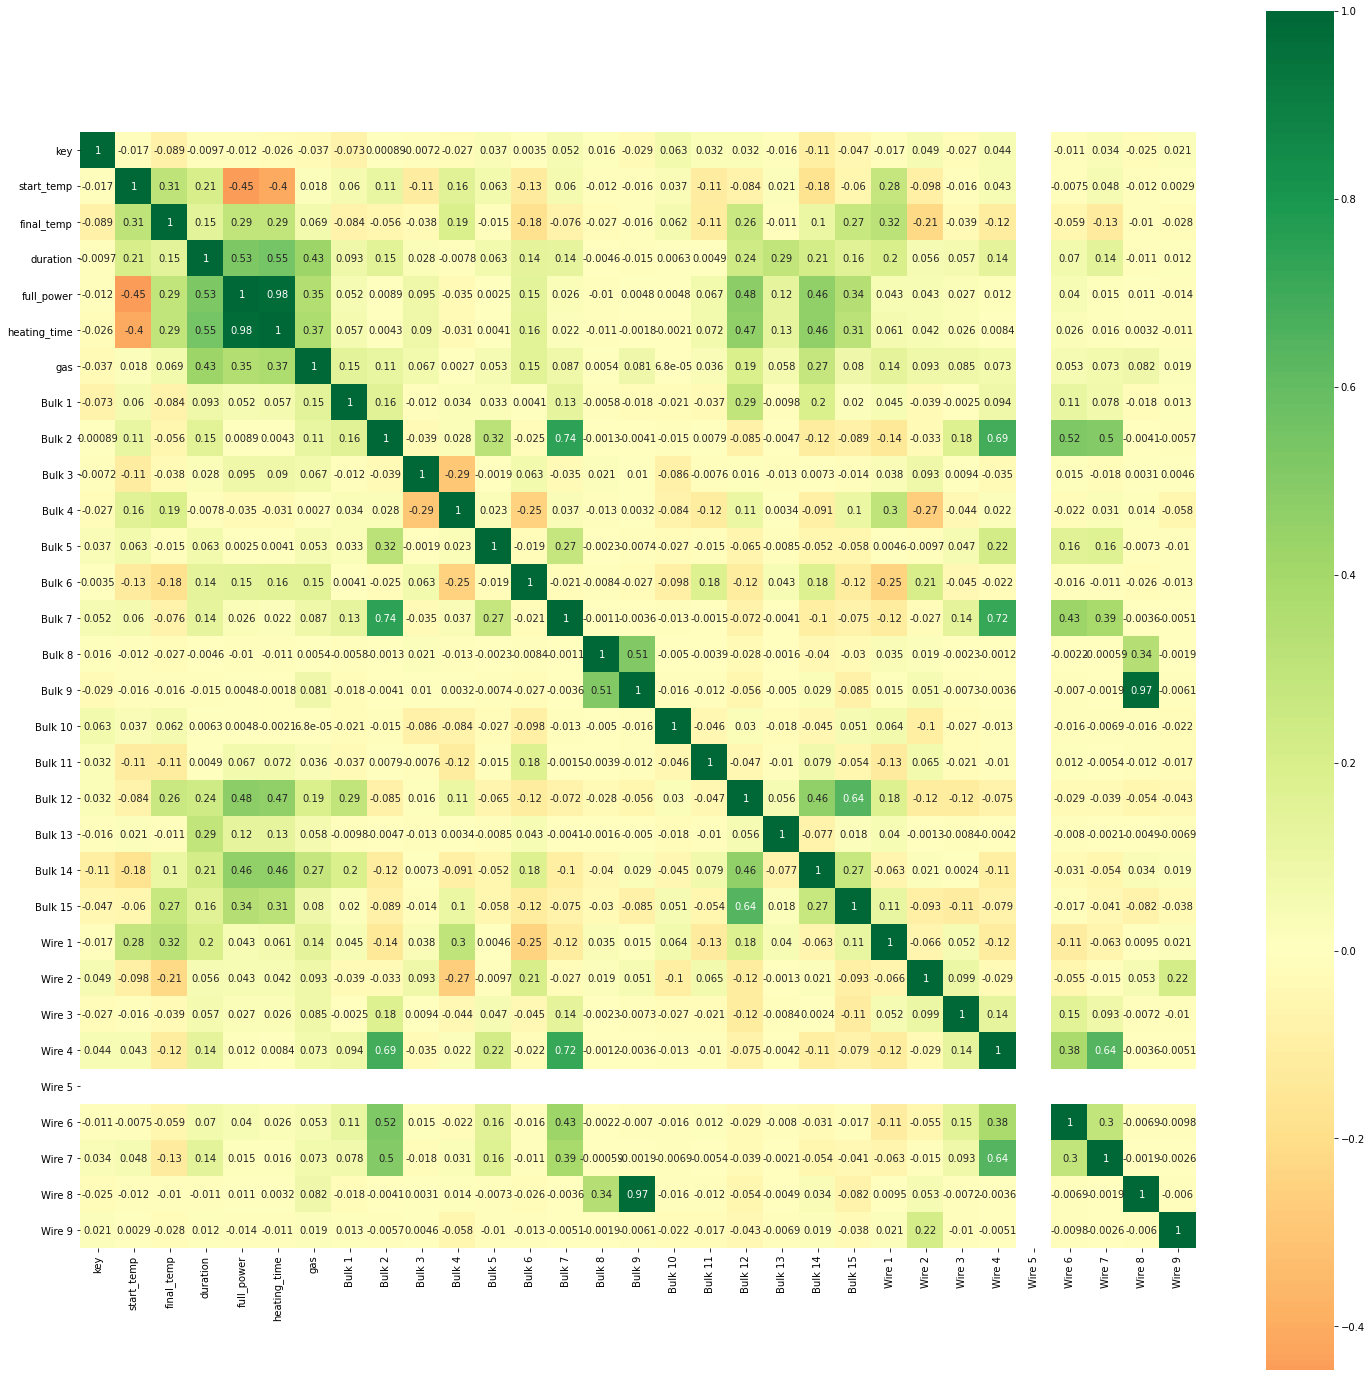

In [47]:
plt.figure(figsize=(25,25))
sns.heatmap(df_final.corr(), annot=True, cmap='RdYlGn', center=0, square=True)
plt.show()

Видим, что по столбцу `Wire 5` везде нулевая корреляция. Проверим, может он вообще пустой.

In [48]:
df_final[df_final['Wire 5'] > 0]

,key,start_temp,final_temp,duration,full_power,heating_time,gas,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9


Столбец `Wire 5` не содержит ни одного значения выше нуля, можно его удалить. Также видим корреляцию в 0,97 между столбцами `Bulk 9` и `Wire 8`, а также коррелляцию в 0.98 между столбцами `heating_time` и `full_power`. Поэтому столбцы `Wire 8` и `heating_time` тоже можно удалить.

In [49]:
df_final = df_final.drop(['heating_time', 'Wire 5', 'Wire 8'], axis=1)

Наш датасет готов к обучению моделей.

### Вывод по разделу:
1. В датасет df_arc были добавлены столбцы с полной мощностью и продолжительностью нагрева.
2. В датасетах df_bulk и df_wire все пропуски были заменены нулями, т.к. пропуск означает то, что на конкретном этапе нагрева данные добавки не использовались.
3. В датасете df_gas были удалены выбросы со значением свыше 34.
4. В датасете df_temp были удалены выбросы ниже 1300 градусов, т.к. это минимальная температура плавления стали. Еще были отфильтрованы ключи со всего одним временем замера. Также была определена начальная и конечная температура сплава в одной партии, где конечная температура будет являться целевым признаком.
5. Все обработанные датасеты были объединены в один датасет df_final по ключу `key`. Получилось 2313 строк и 30 столбцов.
6. Для финального датасета был построен heatmap с корреляцией признаков. В результате из датасета был удален столбец `Wire 5`, т.к. он оказался пустым без единого значения, столбец `Wire 8`, т.к. у него была корреляция со столбцом `Bulk 9`, равная 0,97 и столбец `heating_time`, т.к. у него была корреляция со столбцов `full_power` равная 0,98.

## Обучение моделей

Обучим 4 модели: линейную регрессию, случайный лес, Catboost и LightGBM.

In [50]:
#разделим признаки
features = df_final.drop(['key', 'final_temp'], axis=1)
target = df_final['final_temp']

print('Размер датасета с признаками:', features.shape)
print('Размер датасета с целевым признаком:', target.shape)

Размер датасета с признаками: (2313, 26)
Размер датасета с целевым признаком: (2313,)


In [51]:
#выделим обучающую и тестовую выборки в соотношении 3:1
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=20220809)
print('Размер обучающей выборки:', len(target_train))
print('Размер тестовой выборки:', len(target_test))

Размер обучающей выборки: 1734
Размер тестовой выборки: 579


### Линейная регрессия

Первой обучим линейную регрессию.

In [53]:
linear_model = LinearRegression(n_jobs=-1)
linear_model.fit(features_train, target_train)
linear_score = cross_val_score(linear_model, features_train, target_train,
                               cv=5, scoring='neg_mean_absolute_error').mean()
 
print('MAE линейной регрессии на обучающей выборке:', abs(linear_score))

MAE линейной регрессии на обучающей выборке: 5.891506941288785


При кросс-валидации уже на линейной регрессии получили отличный результат MAE - 5.89.

### Случайный лес

In [54]:
%%time

forest_model = RandomForestRegressor(random_state=20220809)
forest_params = {'n_estimators':range(50, 500, 50), 'max_depth':range(10, 50, 5)}
forest_grid = GridSearchCV(forest_model, forest_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
forest_grid.fit(features_train, target_train)
forest_score = cross_val_score(forest_grid, features_train, target_train,
                               cv=5, scoring='neg_mean_absolute_error').mean()

print('Лучшие параметры случайного леса:', forest_grid.best_params_)
print('MAE случайного леса на обучающей выборке:', abs(forest_score))

Лучшие параметры случайного леса: {'max_depth': 25, 'n_estimators': 400}
MAE случайного леса на обучающей выборке: 5.921362280958269
CPU times: total: 17.6 s
Wall time: 6min 34s


У случайного леса метрика MAE чуть хуже, чем у линейной регрессии - 5.92.

### Catboost

In [55]:
%%time

cat_model = CatBoostRegressor(iterations=100, verbose=False, random_state=20220809)
cat_params = {'learning_rate':[0.01, 0.05, 0.1], 'depth':range(5, 15, 2)}
cat_grid = GridSearchCV(cat_model, cat_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
cat_grid.fit(features_train, target_train)
cat_score = cross_val_score(cat_grid, features_train, target_train,
                               cv=5, scoring='neg_mean_absolute_error').mean()

print('Лучшие параметры Catboost:', cat_grid.best_params_)
print('MAE Catboost на обучающей выборке:', abs(cat_score))

Лучшие параметры Catboost: {'depth': 7, 'learning_rate': 0.1}
MAE Catboost на обучающей выборке: 5.771511321025834
CPU times: total: 12 s
Wall time: 15min 5s


Catboost продемонстрировал результат еще лучше, чем предыдущие модели - 5.77.

### LightGBM

In [56]:
%%time

gbm_model = LGBMRegressor(random_state=20220809)
gbm_params = {'n_estimators':range(50, 500, 50), 'num_leaves':range(10, 20, 2)}
gbm_grid = GridSearchCV(gbm_model, gbm_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
gbm_grid.fit(features_train, target_train)
gbm_score = cross_val_score(gbm_grid, features_train, target_train,
                               cv=5, scoring='neg_mean_absolute_error').mean()

print('Лучшие параметры LightGBM:', gbm_grid.best_params_)
print('MAE LightGBM на обучающей выборке:', abs(gbm_score))

Лучшие параметры LightGBM: {'n_estimators': 100, 'num_leaves': 18}
MAE LightGBM на обучающей выборке: 5.747921134654371
CPU times: total: 6.31 s
Wall time: 21.6 s


LightGBM показал самый лучший результат MAE среди четырех моделей - 5.74, при этом он еще и работает быстрее, чем Catboost и случайный лес.

Для проверки на тестовой выборке остановимся на LightGBM.

Создадим сводную таблицу с результатами работы моделей.

In [57]:
data={'Модель': ['Linear Regression', 'RandomForest', 'CatBoost', 'LightGBM'],
      'MAE': [5.89, 5.92, 5.77, 5.74]}
data_pivot=pd.DataFrame.from_dict(data)
display(data_pivot)

,Модель,MAE
0,Linear Regression,5.89
1,RandomForest,5.92
2,CatBoost,5.77
3,LightGBM,5.74


### Тестирование модели

In [61]:
gbm_test_model = gbm_grid.best_estimator_
gbm_test_model.fit(features_train, target_train)
gbm_predictions = gbm_test_model.predict(features_test)
print('MAE LightGBM на тестовой выборке составляет:', mae(target_test, gbm_predictions))

MAE LightGBM на тестовой выборке составляет: 5.532867650633162


Получили отличный результат MAE на тестовой выборке - 5.53. Для проверки адекватности модели сравним результат с Dummy моделью.

In [62]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(features_train, target_train)
dummy_predictions = dummy.predict(features_test)
print('MAE Dummy модели на тестовой выборке составляет:', mae(target_test, dummy_predictions))

MAE Dummy модели на тестовой выборке составляет: 7.74702137280799


Dummy модель продемонстрировала MAE в 7.74. Результат хуже, чем у всех наших моделей.

Посмотрим на гистограмму важности признаков.

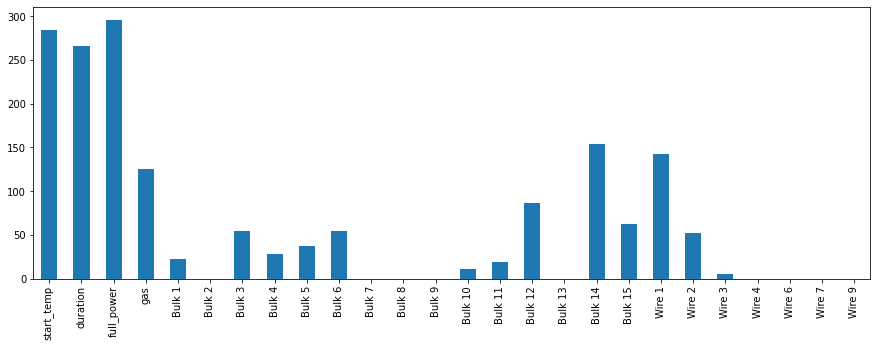

In [63]:
importances = pd.Series(gbm_test_model.feature_importances_, index=features_train.columns)

plt.figure(figsize=(15,5))
importances.plot.bar()
plt.show()

Самыми важными признаками при обучении оказались: `start_temp`, `duration` и `full_power`, которые были подготовлены и выделены нами самостоятельно.

### Вывод по разделу


1. Были обучены 4 модели: линейная регрессия, случайный лес Catboost и LightGBM. Лучшую метрику MAE достиг LightGBM - 5.74, следом идет Catboost с результатом 5.77. В результате было принято решение на тестовой выборке проверять LightGBM.
2. На тестовой выборке LightGBM достиг отличный результат МАЕ равный 5.53.
3. Исходя из гистограммы важности признаков самыми важными признаками при обучении оказались: start_temp, duration и full_power, которые были подготовлены и выделены нами самостоятельно.

## Общий вывод

1. ***Были загружены и изучены 7 датасетов:***
    - `data_arc` — данные об электродах;
    - `data_bulk` — данные о подаче сыпучих материалов (объём);
    - `data_bulk_time` — данные о подаче сыпучих материалов (время);
    - `data_gas` — данные о продувке сплава газом;
    - `data_temp` — результаты измерения температуры;
    - `data_wire` — данные о проволочных материалах (объём);
    - `data_wire_time` — данные о проволочных материалах (время).

В датасете `data_arc` 5 столбцов и 14 876 строк. Пропусков и дубликатов нет. Столбцы "Начало нагрева дугой" и "Конец нагрева дугой" были приведены к типу datetime. В столбце `реактивная мощность` найден выброс, равный -715.504924, который был удален. Распределение в датасете в целом нормальное, с перекосом вправо.<br>
В датасетах `data_bulk` и `data_bulk_time` по 3129 строк и 16 столбцов. Дубликатов нет. В данных очень много пропусков, потому что данные примеси добавлялись не в каждый сплав и не каждый раз, а только при необходимости изменить состав.<br>
В датасетах `data_wire` и `data_wire_time` по 3081 строке и по 10 столбцов. Дубликатов нет. Здесь наблюдается точно такая же картина, как и в предыдущих датасетах `bulk`: очень много пропусков по той же причине.<br>
В датасете `data_gas` 3239 строк и всего 2 столбца. Пропусков и дубликатов нет. Было определено, что все значения свыше 34 являются выбросами.
В датасете `data_temp` 15 907 строк и 3 столбца. В столбце "Температура" есть 2 906 пропусков. Дубликаты отсутствуют. Столбец "Время замера" был приведен к типу datetime. В датасете были обнаружены выбросы. Распределение абсолютно нормальное.

2. ***При предобработке данных:***
    1. В датасет df_arc были добавлены столбцы с полной мощностью и продолжительностью нагрева. 
    2. В датасетах df_bulk и df_wire все пропуски были заменены нулями, т.к. пропуск означает то, что на конкретном этапе нагрева данные добавки не использовались.
    3. В датасете df_gas были удалены выбросы со значением свыше 34.
    4. В датасете df_temp были удалены выбросы ниже 1300 градусов, т.к. это минимальная температура плавления стали. Также были отфильтрованы ключи со всего одним временем замера. Была определена начальная и конечная температура сплава в одной партии, где конечная температура будет являться целевым признаком.
    5. Все обработанные датасеты были объединены в один датасет `df_final` по ключу `key`. Получилось 2313 строк и 31 столбца.
    6. Датасеты `data_bulk_time` и `data_wire_time` не были использованы при формировании финального датасета.
    7. Для финального датасета был построен heatmap с корреляцией признаков. В результате из датасета был удален столбец `Wire 5`, т.к. он оказался пустым без единого значения, столбец `Wire 8`, т.к. у него была корреляция со столбцом `Bulk 9`, равная 0,97 и столбец `heating_time`, т.к. у него была корреляция со столбцов `full_power` равная 0,98.
    
3. ***Обучение моделей:***
    1. Были обучены 4 модели: линейная регрессия, случайный лес Catboost и LightGBM. Лучшую метрику MAE достиг LightGBM - 5.74, следом идет Catboost с результатом 5.77. В результате было принято решение на тестовой выборке проверять LightGBM.
    2. **На тестовой выборке LightGBM достиг отличный результат МАЕ равный 5.53.**
    3. Исходя из гистограммы важности признаков самыми важными признаками при обучении оказались: start_temp, duration и full_power, которые были подготовлены и выделены нами самостоятельно.

4. ***Рекомендации заказчику для экономии энергоресурсов:***
    1. Судя по модели, самым важным фактором является начальная температура. Это значит, что управляя ею, мы сможем управлять энергозатратами. Теперь надо разработать мероприятия для этого решения. И тут возникает вопрос: можно ли управлять начальной температурой и что для этого нужно сделать?
    2. У нас есть разброс в измерениях. Тогда задачу можно поставить так: нужно уменьшить разброс в измерениях, а в данном случае в температуре. Один из подходов такой: наверняка есть границы, в пределах которых колебания температур - дело нормальное. Предлагаю фиксировать случаи, когда температура выходит за эти границы, скажем отмечать, как "1". И тогда для таких моментов времени собирать инфо по производству: а что был за материал (химия материала), что был за газ (химический состав газа), какая бригада работала, что там было с электродами, ну и остальные моменты, связанные со знанием процесса производства. И тут мы можем находить реальные причины (через корреляции, проверки гипотез, разные модели), фиксировать эти причины и на основании этого разрабатывать более эффективные энергосберегательные мероприятия.